In [167]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
import scipy.stats as scistats
from mcareader import Mca
import scipy.signal as fp
import os
import re

In [168]:
def extract_mca_data(file_path):
    data_values = []
    inside_data_section = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "<<DATA>>":
                inside_data_section = True
                continue
            if line == "<<END>>":
                break
            if inside_data_section and line.isdigit():
                data_values.append(int(line))
    return data_values

In [ ]:
import os
import re

directory = "team_battery"

# Regex to capture both numbers, e.g., '2' and '1760' from systemba_2_1760.mca
pattern = re.compile(r"systemba_(\d+)_(\d+)\.mca")

temp_storage = []
gain_list = []

for filename in os.listdir(directory):
    match = pattern.search(filename)
    if match:
        gain = float(match.group(1))     # First number (gain)
        x_value = float(match.group(2))  # Second number (e.g. 1760)
        file_path = os.path.join(directory, filename)
        data = extract_mca_data(file_path)
        temp_storage.append((x_value, data))
        gain_list.append(gain)

# Sort temp_storage and gain_list together based on x_value (second number)
sorted_pairs = sorted(zip(temp_storage, gain_list), key=lambda item: item[0][0])

# Unpack sorted results
temp_storage_sorted = [item[0] for item in sorted_pairs]
gain_list_sorted = [item[1] for item in sorted_pairs]

file_labels = [item[0] for item in temp_storage_sorted]
all_data_lists = [item[1] for item in temp_storage_sorted]

print(f"Loaded {len(all_data_lists)} files in ascending order of X.")
for i, data_list in enumerate(all_data_lists):
    print(f"File {i+1} (X={file_labels[i]}, Gain={gain_list_sorted[i]}): {len(data_list)} points")


Loaded 0 files in ascending order of X.


In [170]:
# directory = "team_battery"

# # Regex to capture the float X from filenames like cal_10_(X).mca
# pattern = re.compile(r"fe_\d+\_(\d*)\.mca")

# # Temporary storage for (x_value, data_list)
# temp_storage = []

# for filename in os.listdir(directory):
#     match = pattern.search(filename)
#     if match:
#         x_value = float(match.group(1))
#         file_path = os.path.join(directory, filename)
#         data = extract_mca_data(file_path)
#         temp_storage.append((x_value, data))

# # Sort by x_value
# temp_storage.sort(key=lambda item: item[0])

# # Separate into two lists
# file_labels = [item[0] for item in temp_storage]
# all_data_lists = [item[1] for item in temp_storage]


# print(f"Loaded {len(all_data_lists)} files in ascending order of X.")
# # for i, data_list in enumerate(all_data_lists):
# #     print(f"File {i+1} (X={file_labels[i]}): {len(data_list)} points")

In [171]:
bkg=extract_mca_data('team_battery/bkg_10_1789.mca')

In [172]:
index=6
minimum_expected_peak_height=40
minimum_bin_distance_between_peaks=100
minimum_peak_width=8
maximum_peak_width=200
minimum_peak_prominence=None
# threshold=13

channel_no=np.linspace(0,len(all_data_lists[index]),1024)

IndexError: list index out of range

In [ ]:
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))

In [ ]:
def bkg_corrector(bkg_list,data_list,index):
    bkg_corr_data_list=[]
    for i in range(0,len(bkg_list)):
        bkg_corr_data=data_list[index][i]-bkg_list[i]
        bkg_corr_data_list.append(bkg_corr_data)
    bkg_corr_data_list=np.array(bkg_corr_data_list).clip(min=0)
    return bkg_corr_data_list

In [ ]:
def peak_fitter(function, channel, data_list,fit_range,init_guess):
    mu, cov=sci.curve_fit(function,channel[fit_range[0]:fit_range[1]],data_list[fit_range[0]:fit_range[1]],p0=init_guess,maxfev=5000)
    gauss=gaussian(channel[fit_range[0]:fit_range[1]],*mu)
    channel_no_ranged=channel[fit_range[0]:fit_range[1]]
    return channel_no_ranged, gauss, mu, cov

In [ ]:
# NO THRESHOLD - MODIFIED TO DETECT ONLY 2 HIGHEST PEAKS
def peak_scouter(index, minimum_expected_peak_height, minimum_bin_distance_between_peaks, minimum_peak_width, maximum_peak_width, minimum_peak_prominence, bkg, all_data_lists):
    peak_pnts = []
    range_list = []
    p0_list = []
    bkg_corr_ind = bkg_corrector(bkg, all_data_lists, index)
    
    # Find all peaks first
    peaks, properties = fp.find_peaks(
        bkg_corr_ind,
        height=minimum_expected_peak_height,   # Filter noise, set to a value below expected peaks
        distance=minimum_bin_distance_between_peaks,  # To avoid detecting overlapping peaks
        width=(minimum_peak_width, maximum_peak_width),   # Accept variable peak widths
        prominence=minimum_peak_prominence,    # For sharper peaks, avoids flat humps
        rel_height=0.5
    )
    
    peak_bins = peaks
    peak_heights = properties["peak_heights"]
    peak_positions = channel_no[peak_bins]
    peak_widths = properties["widths"]
    
    # Sort peaks by height (descending order) and take only the top 2
    if len(peak_heights) > 2:
        # Get indices of the 2 highest peaks
        top_indices = np.argsort(peak_heights)[-2:][::-1]  # [::-1] to get descending order
        
        # Keep only the top 2 peaks
        peak_bins = peak_bins[top_indices]
        peak_heights = peak_heights[top_indices]
        peak_positions = peak_positions[top_indices]
        peak_widths = peak_widths[top_indices]
    
    print("Rough peak positions:", peak_positions)
    print("NO. PEAKS DETECTED:", len(peak_positions))
    print("Peak heights:", peak_heights)
    
    for i in peak_bins:
        peak_ind = bkg_corr_ind[i]
        peak_pnts.append(peak_ind)
        
    for i in range(len(peak_bins)):
        lower_lim = peak_bins[i] - 1 * peak_widths[i]
        upper_lim = peak_bins[i] + 1 * peak_widths[i] 
        fit_range = [int(lower_lim + 1), int(upper_lim + 1)]
        range_list.append(fit_range)
        
        a_est = peak_heights[i]
        mu_est = peak_positions[i]
        sigma_est = peak_widths[i]
        init_guess = [a_est, mu_est, sigma_est]
        p0_list.append(init_guess)
        
    return peak_pnts, peak_bins, peak_positions, peak_widths, range_list, p0_list, bkg_corr_ind

In [ ]:
def graphfitter(range_list,function,channels,bkg_corr_data,p0_list):
    ranged_channel_list=[]
    fit_gauss_list=[]
    for peaks in range(0,len(range_list)):
        ranged_channel,fit_gauss,mu,cov  = peak_fitter(function,channels,bkg_corr_data,range_list[peaks],p0_list[peaks])
        ranged_channel_list.append(ranged_channel)
        fit_gauss_list.append(fit_gauss)
        centroid_error=np.sqrt(np.diag(cov))
        centroid=mu[1]
        print(f"The fitting range for peak {peaks}:",ranged_channel[0],ranged_channel[-1])
        print(f"The centroid for peak {peaks}:",mu[1])
        print(f"The error on the centroid fit for peak {peaks}:", centroid_error[1])
    return ranged_channel_list, fit_gauss_list,centroid

In [ ]:
def charge_cali(channels):
    charge_list=[]
    for i in range(0,len(channels)):
        charge= (1.751e-13*channels[i]) + 1.164e-12
        charge_list.append(charge)
    return charge_list

In [ ]:
peak_pnts, peak_bins, peak_positions, peak_width, range_list, p0_list, bkg_corr_ind  =  peak_scouter(index,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,bkg,all_data_lists)

Rough peak positions: [123.1202346]
NO. PEAKS DETECTED: 1
Peak heights: [253.]


In [ ]:
ranged_channel_list,fit_gauss_list,centroid = graphfitter(range_list,gaussian,channel_no,bkg_corr_ind,p0_list)

The fitting range for peak 0: 107.10459433040079 139.13587487781035
The centroid for peak 0: 122.48387467391358
The error on the centroid fit for peak 0: 0.24416069025197146


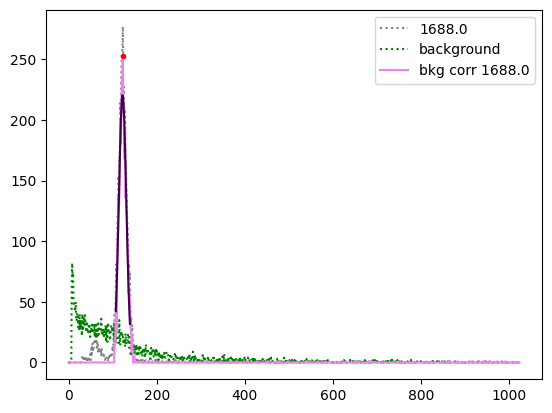

Initial guess list [[np.float64(253.0), np.float64(123.12023460410558), np.float64(16.83080808080807)]]
Fitting range for each peak [[107, 140]]


In [ ]:
#plotting the curve and the peaks (Still working on the automatic fitting, worst case scenario we can just manually fit the curves)
peakcolors=len(ranged_channel_list)
peaklegend=plt.cm.PRGn(np.linspace(0,1,peakcolors))
fig, ax = plt.subplots()
ax.plot(channel_no,all_data_lists[index],label=file_labels[index],color='grey',linestyle='dotted')
ax.plot(channel_no,bkg,label='background',color='green',linestyle='dotted')
ax.plot(channel_no,bkg_corr_ind,label=f'bkg corr {file_labels[index]}',color='violet')
ax.plot(peak_positions,peak_pnts,'r.')
for fitpeak in range(0,len(ranged_channel_list)):
    ax.plot(ranged_channel_list[fitpeak],fit_gauss_list[fitpeak],color=peaklegend[fitpeak])
ax.legend()
# plt.xlim(0,200)
plt.show()
print("Initial guess list",p0_list)
print("Fitting range for each peak",range_list)




In [ ]:
# for bias_voltage in range(0,len(all_data_lists)):
#     print("BIAS VOLTAGE",file_labels[bias_voltage],": Index",bias_voltage)
#     peak_pnts, peak_bins, peak_positions, peak_width, range_list, p0_list,bkg_corr_ind  =  peak_scouter(bias_voltage,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,bkg,all_data_lists)

FINAL FIT TESTING CODE


Processing bias voltage 1388.0 (Index 0)
Rough peak positions: [46.04496579]
NO. PEAKS DETECTED: 1
Peak heights: [305.]

Fitting peaks for bias voltage 1388.0:
  Peak 1: Centroid = 45.538 ± 0.129
✓ Successfully fitted 1 peaks

Processing bias voltage 1448.0 (Index 1)
Rough peak positions: [65.06353861]
NO. PEAKS DETECTED: 1
Peak heights: [289.]

Fitting peaks for bias voltage 1448.0:
  Peak 1: Centroid = 64.372 ± 0.151
✓ Successfully fitted 1 peaks

Processing bias voltage 1508.0 (Index 2)
Rough peak positions: [96.09384164]
NO. PEAKS DETECTED: 1
Peak heights: [218.]

Fitting peaks for bias voltage 1508.0:
  Peak 1: Centroid = 92.908 ± 0.183
✓ Successfully fitted 1 peaks

Processing bias voltage 1568.0 (Index 3)
Rough peak positions: [132.12903226]
NO. PEAKS DETECTED: 1
Peak heights: [185.]

Fitting peaks for bias voltage 1568.0:
  Peak 1: Centroid = 135.046 ± 0.249
✓ Successfully fitted 1 peaks

Processing bias voltage 1568.0 (Index 4)
Rough peak positions: [55.05376344]
NO. PEAKS DE

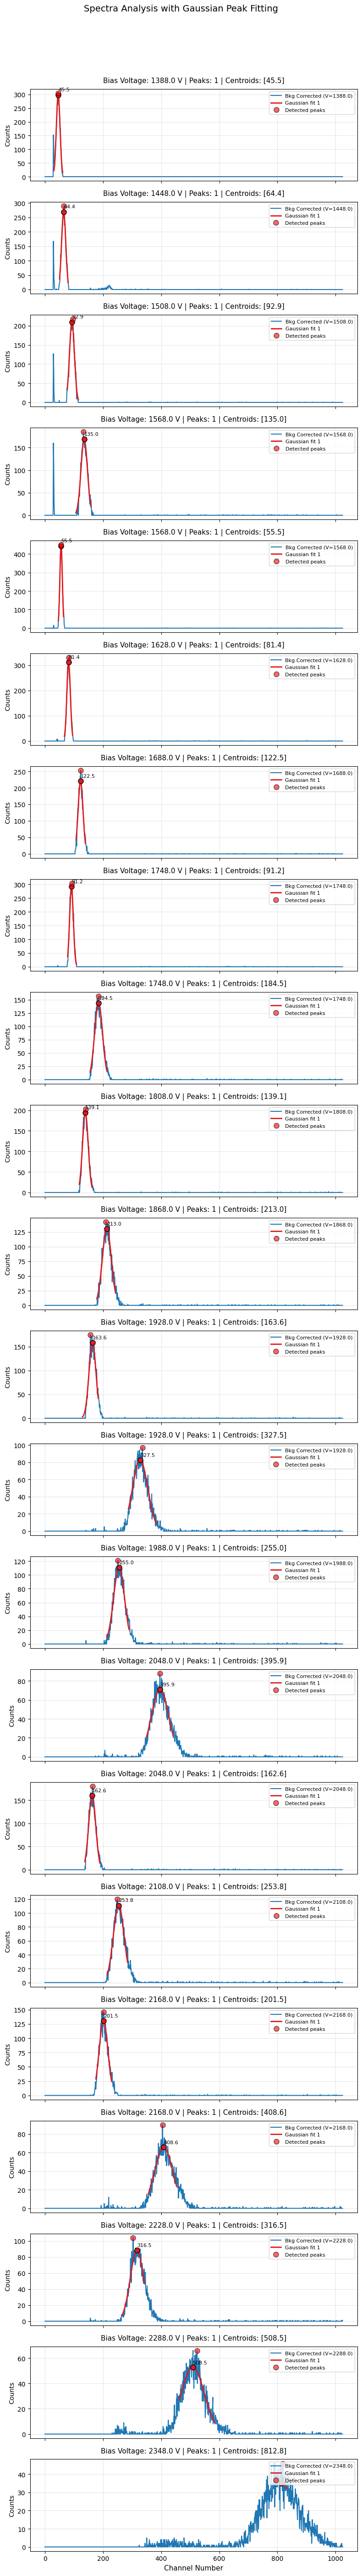


PROCESSING SUMMARY
Total spectra processed: 22
Total peaks fitted: 22

CENTROID SUMMARY

Spectrum 0 (Bias Voltage: 1388.0):
  Peak 1: Centroid = 45.538 ± 0.129

Spectrum 1 (Bias Voltage: 1448.0):
  Peak 1: Centroid = 64.372 ± 0.151

Spectrum 2 (Bias Voltage: 1508.0):
  Peak 1: Centroid = 92.908 ± 0.183

Spectrum 3 (Bias Voltage: 1568.0):
  Peak 1: Centroid = 135.046 ± 0.249

Spectrum 4 (Bias Voltage: 1568.0):
  Peak 1: Centroid = 55.529 ± 0.076

Spectrum 5 (Bias Voltage: 1628.0):
  Peak 1: Centroid = 81.366 ± 0.155

Spectrum 6 (Bias Voltage: 1688.0):
  Peak 1: Centroid = 122.484 ± 0.244

Spectrum 7 (Bias Voltage: 1748.0):
  Peak 1: Centroid = 91.204 ± 0.154

Spectrum 8 (Bias Voltage: 1748.0):
  Peak 1: Centroid = 184.514 ± 0.319

Spectrum 9 (Bias Voltage: 1808.0):
  Peak 1: Centroid = 139.059 ± 0.234

Spectrum 10 (Bias Voltage: 1868.0):
  Peak 1: Centroid = 212.956 ± 0.380

Spectrum 11 (Bias Voltage: 1928.0):
  Peak 1: Centroid = 163.583 ± 0.301

Spectrum 12 (Bias Voltage: 1928.0):
  

In [ ]:
channel_no = np.linspace(0, 1024, 1024)

def plot_all_spectra_with_fits(all_data_lists, bkg, file_labels):
    n = len(all_data_lists)
    fig, axes = plt.subplots(n, 1, figsize=(8, 2.5*n), sharex=True)
    if n == 1:
        axes = [axes]

    all_fit_ranges = []   # will hold ranges for each spectrum
    all_fit_results = []  # will hold fitting results for each spectrum
    all_centroids = []    # NEW: will hold centroids for each spectrum

    for idx in range(n):
        print(f"\n{'='*50}")
        print(f"Processing bias voltage {file_labels[idx]} (Index {idx})")
        print(f"{'='*50}")
        ax = axes[idx]

        # Background-corrected data
        bkg_corr = bkg_corrector(bkg, all_data_lists, idx)

        # Find peaks and fitting parameters with your peak_scouter
        (peak_pnts, peak_bins, peak_positions,
         peak_width, range_list, p0_list, bkg_corr_ind) = peak_scouter(
            idx,
            minimum_expected_peak_height,
            minimum_bin_distance_between_peaks,
            minimum_peak_width,
            maximum_peak_width,
            minimum_peak_prominence,
            bkg,
            all_data_lists
        )

        # Convert this spectrum's ranges to [[x1, x2], [x3, x4], ...]
        this_fit_ranges = [[float(r[0]), float(r[1])] for r in range_list]
        all_fit_ranges.append(this_fit_ranges)
        
        # Plot background corrected spectrum
        ax.plot(channel_no, bkg_corr, label=f"Bkg Corrected (V={file_labels[idx]})", color="C0", linewidth=1.5)

        # Fit peaks using graphfitter if any peaks were detected
        if len(peak_positions) > 0:
            print(f"\nFitting peaks for bias voltage {file_labels[idx]}:")
            
            # Create lists to store fitting results for this spectrum
            spectrum_centroids = []  # NEW: store centroids for this spectrum
            spectrum_fit_results = []
            ranged_channel_list = []
            fit_gauss_list = []
            
            # Fit each peak individually to extract centroids
            for i, (fit_range, init_guess) in enumerate(zip(range_list, p0_list)):
                ranged_channel, fit_gauss, mu, cov = peak_fitter(
                    gaussian, channel_no, bkg_corr_ind, fit_range, init_guess
                )
                
                centroid = mu[1]  # Extract centroid (mu parameter)
                centroid_error = np.sqrt(np.diag(cov))[1]  # Error on centroid
                
                spectrum_centroids.append({
                    'centroid': centroid,
                    'centroid_error': centroid_error,
                    'amplitude': mu[0],
                    'sigma': mu[2]
                })
                
                ranged_channel_list.append(ranged_channel)
                fit_gauss_list.append(fit_gauss)
                
                print(f"  Peak {i+1}: Centroid = {centroid:.3f} ± {centroid_error:.3f}")
            
            # Store centroids for this spectrum
            all_centroids.append(spectrum_centroids)
            
            # Store fit results
            for i, (ranged_channel, fit_gauss) in enumerate(zip(ranged_channel_list, fit_gauss_list)):
                spectrum_fit_results.append({
                    'channel_range': [ranged_channel[0], ranged_channel[-1]],
                    'fitted_gaussian': fit_gauss,
                    'centroid': spectrum_centroids[i]['centroid'],
                    'centroid_error': spectrum_centroids[i]['centroid_error']
                })
            all_fit_results.append(spectrum_fit_results)
            
            # Plot Gaussian fits with different colors
            colors = plt.cm.Set1(np.linspace(0, 1, len(fit_gauss_list)))
            for i, (ranged_channel, fit_gauss, color) in enumerate(zip(ranged_channel_list, fit_gauss_list, colors)):
                # Plot the fitted Gaussian curve
                ax.plot(ranged_channel, fit_gauss, color=color, linewidth=2, 
                       label=f'Gaussian fit {i+1}' if i < 5 else '')
                
                # Mark the centroid of the Gaussian fit
                centroid = spectrum_centroids[i]['centroid']
                # Find the max value of the fitted Gaussian
                fit_max = np.max(fit_gauss)
                ax.plot(centroid, fit_max, 'o', color=color, markersize=8, 
                       markeredgecolor='black', markeredgewidth=1)
                
                # Annotate the centroid value
                ax.text(centroid, fit_max + fit_max*0.05, f'{centroid:.1f}', 
                       fontsize=8, ha='left', color='black')

        # Plot peak positions as points
        for bin_idx, peak_height in zip(peak_bins, peak_pnts):
            x = channel_no[bin_idx]
            y = peak_height
            ax.plot(x, y, "ro", markersize=8, alpha=0.6, markeredgecolor='black', 
                   label='Detected peaks' if bin_idx == peak_bins[0] else '')

        # Set plot details
        ax.set_ylabel("Counts", fontsize=10)
        
        # Create legend with unique entries
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Remove duplicates
        ax.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=8)
        
        # Add centroid information to title if available
        title = f"Bias Voltage: {file_labels[idx]} V | Peaks: {len(peak_positions)}"
        if len(peak_positions) > 0 and spectrum_centroids:
            centroids_str = ', '.join([f'{c["centroid"]:.1f}' for c in spectrum_centroids])
            title += f" | Centroids: [{centroids_str}]"
        
        ax.set_title(title, fontsize=11, pad=10)
        ax.grid(True, alpha=0.3)
        
        # Set x-limits
        # ax.set_xlim(0, 400)
        
        # Print summary for this spectrum
        if len(peak_positions) > 0:
            print(f"✓ Successfully fitted {len(ranged_channel_list)} peaks")

    axes[-1].set_xlabel("Channel Number", fontsize=11)
    plt.suptitle("Spectra Analysis with Gaussian Peak Fitting", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*60}")
    print("PROCESSING SUMMARY")
    print(f"{'='*60}")
    total_peaks = sum([len(ranges) for ranges in all_fit_ranges])
    print(f"Total spectra processed: {n}")
    print(f"Total peaks fitted: {total_peaks}")
    
    # Print all centroids
    print(f"\n{'='*60}")
    print("CENTROID SUMMARY")
    print(f"{'='*60}")
    for idx, centroids in enumerate(all_centroids):
        print(f"\nSpectrum {idx} (Bias Voltage: {file_labels[idx]}):")
        for i, centroid_data in enumerate(centroids):
            print(f"  Peak {i+1}: Centroid = {centroid_data['centroid']:.3f} ± {centroid_data['centroid_error']:.3f}")
    
    # Also print centroids in a compact format
    print(f"\n{'='*60}")
    print("CENTROIDS ONLY (for easy copying):")
    print(f"{'='*60}")
    print("all_centroids = [")
    for idx, centroids in enumerate(all_centroids):
        if centroids:
            centroid_list = [f"{c['centroid']:.3f}" for c in centroids]
            print(f"    # Spectrum {idx} (V={file_labels[idx]}): {centroid_list},")
        else:
            print(f"    # Spectrum {idx} (V={file_labels[idx]}): [],")
    print("]")
    
    return all_fit_ranges, all_fit_results, all_centroids


# Call it:
fit_ranges, fit_results, all_centroids = plot_all_spectra_with_fits(all_data_lists, bkg, file_labels)

PLOTTING THE COMBINED HISTOGRAMS

In [ ]:
# def hist_generator_bkg_corrected(index,data_list,bkg,label_list,color):
#     bkg_correction=bkg_corrector(bkg,data_list,index)
#     # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
#     plt.plot(np.linspace(0,len(data_list[index]),1024),bkg_correction,label=f"corrected {label_list[index]}",color=color)
#     # plt.xlim(0,100)
#     plt.title("Fe55 Combined Histograms (Background corrected)")
#     plt.xlabel("Channel Number")
#     plt.ylabel("Counts")
#     # plt.axline([0,30],slope=0,color='black',linestyle='dashed',linewidth=0.7)
#     plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))


In [ ]:
# def hist_generator(index,data_list,label_list,color):
#     plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index],color=color)
#     # plt.axline([0,30],slope=0,color='black',linestyle='dashed',linewidth=0.7)
#     # plt.xlim(0,100)
#     plt.title("Fe55 Combined Histograms (No background correction)")
#     plt.xlabel("Channel Number")
#     plt.ylabel("Counts")
#     plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))

In [ ]:
def energy_cali(channels):
    energy_list=[]
    for i in range(0,len(channels)):
        energy=0.1035*(channels[i]) - 0.2539
        if energy>0:
            energy_list.append(energy)
    return energy_list

In [ ]:
def hist_generator_bkg_corrected(index,data_list,bkg,label_list,color,channels):
    bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    energy_list=energy_cali(channels)
    plt.plot(energy_list,bkg_correction[-(len(energy_list)):],label=f"corrected {label_list[index]}",color=color)
    # plt.xlim(0,100)
    plt.title("Ba133 Combined Histograms (Background corrected)")
    plt.xlabel("Energy (KeV)")
    plt.ylabel("Counts")
    # plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))

In [ ]:
def hist_generator(index,data_list,bkg,label_list,color,channels):
    # bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    energy_list=energy_cali(channels)
    plt.plot(energy_list,data_list[index][-(len(energy_list)):],label=f"{label_list[index]}",color=color)
    # plt.xlim(0,100)
    # plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.title("Ba133 Combined Histograms (No background correction)")
    plt.xlabel("Energy (KeV)")
    plt.ylabel("Counts")
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))

In [ ]:
numline=len(all_data_lists)
colour=plt.cm.plasma(np.linspace(0,1,numline))

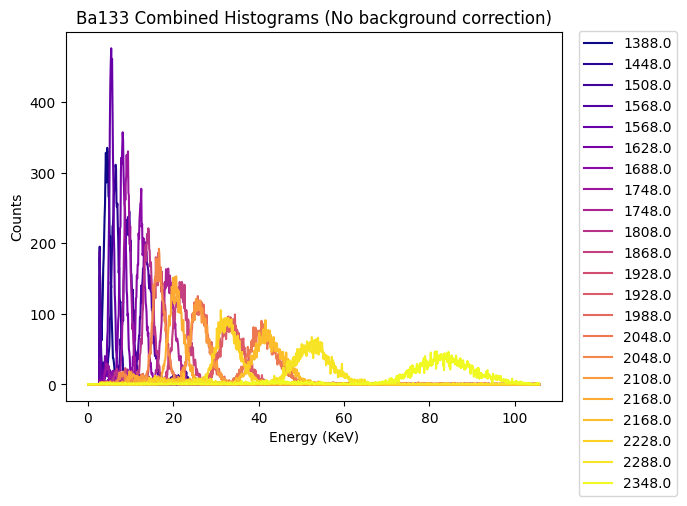

In [ ]:
for i in range(0,len(all_data_lists)):
    hist_generator(i,all_data_lists,bkg,file_labels,colour[i],channel_no)

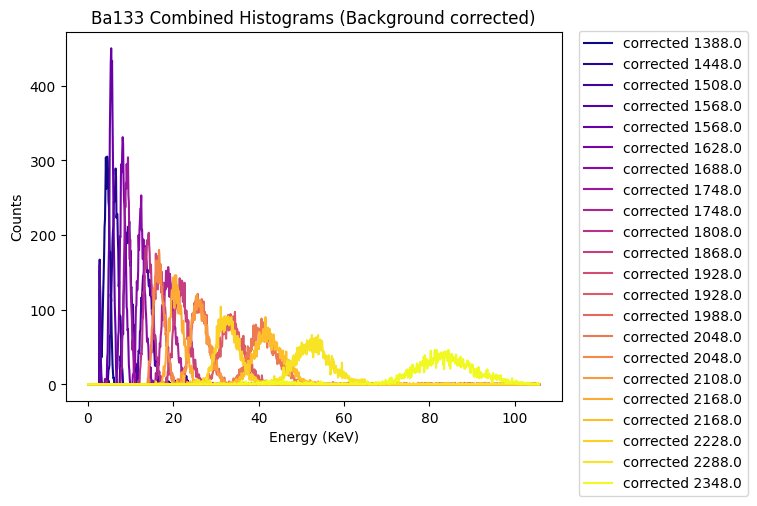

In [ ]:
for i in range(0,len(all_data_lists)):
    hist_generator_bkg_corrected(i,all_data_lists,bkg,file_labels,colour[i],channel_no)
    

Trying to plot the operational region plots

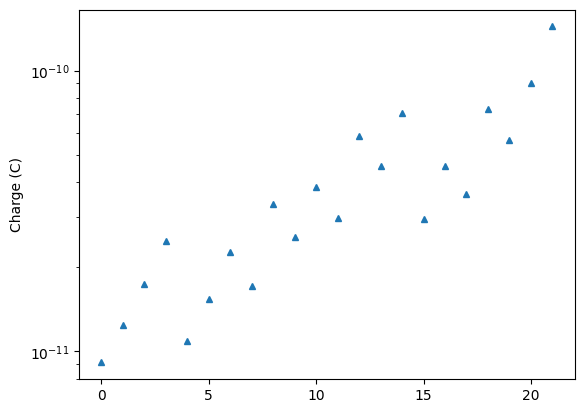

In [ ]:
all_centroid_list=[cent[0]["centroid"] for cent in all_centroids]
all_cent_error_list=[cent[0]["centroid_error"] for cent in all_centroids]
charge_cali_cents=charge_cali(all_centroid_list)
plt.plot(charge_cali_cents,marker='^',ms=5,linestyle='None')
plt.ylabel("Charge (C)")
plt.yscale("log")